In [10]:
import numpy as np
from librosa import load, logamplitude
from librosa.feature import melspectrogram
from tqdm import tqdm_notebook
from multiprocessing import Pool
import pickle

In [11]:
import os
filesNames = os.listdir("./wav")

In [12]:
def get_spectrogram(path):
    """Строим спектограмму из wav файла"""
#   Кстати, поправочка, которая стоила мне нервов: librosa работает только с wav файлами с частотой дискретизации 44,1 кГц
    y, sr = load(path)
    S = melspectrogram(y, sr=sr, n_mels=100)
    log_S = logamplitude(S, ref_power=np.max)
    return log_S

In [13]:
def get_spectrogram_1(x):
#   Отправляем путь к файлу в get_spectrogram()
    i, x = x
    if i % 1000 == 0:
        print(i)
    return get_spectrogram('./wav/' + x)

In [14]:
spectrograms = []
if os.stat("saved_data").st_size != 0:
    spectrograms = pickle.load(open("saved_data", "rb"))

In [15]:
if len(filesNames) != len(spectrograms):
    p = Pool(4)
    spectrograms = p.map(get_spectrogram_1, enumerate(a))
    pickle.dump(spectrograms, open("saved_data", "wb"))    

In [16]:
# Создаем матрицу из нулей (кол-во_аудиофайлов, кол-во_нот_на_клавиатуре_ф-но_=_88)
number_of_notes = 88
data_answ = np.zeros((len(spectrograms), number_of_notes))

In [42]:
for i in range (len(spectrograms)):
#   Берем инфорацию из имени файла, записываем в матрицу единицы напротив звучащих в файле нот
#   file name example 2,23,36,120.mid.wav
    name = a[i][:-8].split(",") 
    for j in range (int(name[0])):
        data_answ[i][int(name[j+1]) - 21] = 1  

In [ ]:
data_answ = np.array(data_answ, dtype=int)

In [27]:
# У всех спектрограмм разное кол-во столбцов (и, возможно, строк)
print (spectrograms[0].shape)
print (spectrograms[1].shape)
print (spectrograms[8000].shape)

(100, 90)
(100, 95)
(100, 145)


In [41]:
# Приведем матрицы к наименьшему размеру, существующему в данной выборке
arr = []
min_num_of_rows = min(list(map(lambda x: np.shape(x)[0], spectrograms)))
min_num_of_cols = min(list(map(lambda x: np.shape(x)[1], spectrograms)))
for i in spectrograms:
    arr.append(i[:min_num_of_rows, :min_num_of_cols])

In [64]:
# Так как spectrograms - лист двумерных массивов, а модель принимает на вход только двумерные массивы, 
# преобразуем spectrograms, сделав из матрицы одномерный массив
spectrograms = np.array([b.ravel() for b in arr])

In [44]:
spectrograms.shape

(21181, 8900)

In [45]:
# выберем достаточно большое рандомное число < 21181
random_number = 15000
X_train = spectrograms[:random_number]
Y_train = data_answ[:random_number]
X_test = spectrograms[random_number:]
Y_test = data_answ[random_number:]

In [47]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook

In [60]:
models = []
if os.stat("Models_trained").st_size != 0:
    models = pickle.load(open("Models_trained", "rb"))

True


In [48]:
if (len(models) != number_of_notes):
    for i in tqdm_notebook(range(number_of_notes)):
        model = LogisticRegression()
        model.fit(X_train, Y_train[:, i])
        models.append(model)
    pickle.dump(models, open("Models_trained", "wb"))

In [50]:
from sklearn.metrics import roc_auc_score
Y_pred_trains =[]
Y_pred_tests = []
for i in tqdm_notebook(range(88)):
    Y_pred_trains.append(models[i].predict(X_train))
    Y_pred_tests.append(models[i].predict(X_test))

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

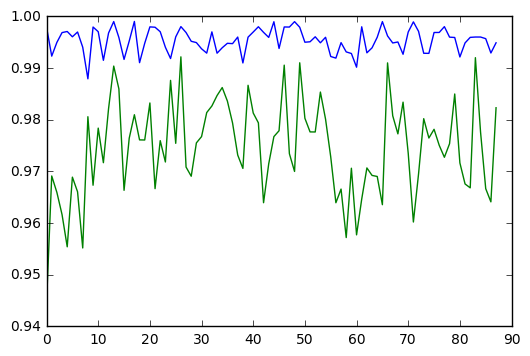

In [52]:
trains = []
tests = []
for i in tqdm_notebook(range(88)):
    trains.append(roc_auc_score(Y_train[:, i],Y_pred_trains[i]))
    tests.append(roc_auc_score(Y_test[:, i],Y_pred_tests[i]))
plt.plot(np.arange(88), np.asarray(trains))
plt.plot(np.arange(88), np.asarray(tests))

In [57]:
train = []
test = []
for i in tqdm_notebook(range(88)):
    train.append(roc_auc_score(Y_train[:, i],Y_pred_trains[i]))
    test.append(roc_auc_score(Y_test[:, i],Y_pred_tests[i]))
print ("Среднее на обучении", np.mean(train))
print ("Среднее на тесте", np.mean(test))


Среднее на обучении 0.99537139148
Среднее на тесте 0.974584294649
